# Sunny with a Chance of Murder
## Data Munging and Analysis with NYC Weather and Crime Data Sets

This notebook is another self-contained, just-for-fun side project to use public data sets (NYC crime data and weather data) to examine the following questions:

  1. What connections can we find between crime rates and weather?  Do crime rates rise with rising  average daily temperature?
  2. What effect does the lunar cycle have on crime rates?  My grandparents always insisted that the full moon turned people into -- well, lunatics.  And they had an abundance of anecdotal evidence to back up their claim.  But what do the data tell us?  
    * The question isn't quite as crazy or supernatural as it sounds.  Perhaps criminals are more likely to burglarize homes when they can see by the light of the moon, without the use of attention-grabbing flashlights.  (On the other hand, perhaps they're _less_ likely to burglarize when their every move is illuminated by the light of the full moon.)  We'll examine the data without prejudice, and without making any statements about my grandparents' credulity.
  3. Are crimes more likely to occur on weekdays vs weekends?  Is the _type_ of crime important for this question?
  4. What's the statistical significance of the differences we identify (if any)?

----

## 1. Obtaining and Cleaning the Data

### 1.1 Scraping Manhattan Weather Data from WeatherUnderground

We'll use the BeautifulSoup library to scrape weather data from html tables on the [WeatherUnderground website](wunderground.com).  We'll begin by doing a quick test: scraping some daily average/max/min temperature data from the web page for  January 1, 2016.

In [2]:
% matplotlib inline

import urllib2
import csv
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
import pylab as pl
import re
import time
import scipy.stats
import scipy.optimize
import random
import copy
import seaborn

We want to cull the hourly weather data for each day in 2012 through 2016 from WeatherUnderground.  The data are recorded in HTML tables, with the data for each date in a separate web page.  We'll define some helper functions that allow us to loop over WeatherUnderground pages for each day, scrape the data from the HTML table, and write it to a single output file.

First, let's do a quick test by scraping some relevant data from a single page on Weather Underground: the mean, maximum, and minimum temperatures recorded for January 1, 2016:

In [3]:
# quick test of page scraping using BeautifulSoup:
url = 'https://www.wunderground.com/history/airport/KNYC/2016/1/1/DailyHistory.html' 
page = urllib2.urlopen(url).read()
soup = BeautifulSoup(page, 'lxml')

meanTemp = soup.find("span", text="Mean Temperature").parent.find_next_sibling("td").get_text(strip=True)
maxTemp = soup.find("span", text="Max Temperature").parent.find_next_sibling("td").get_text(strip=True)
minTemp = soup.find("span", text="Min Temperature").parent.find_next_sibling("td").get_text(strip=True)

print 'Mean Temp:', meanTemp 
print 'Max Temp:', maxTemp 
print 'Min Temp:', minTemp

Mean Temp: 38°F
Max Temp: 42°F
Min Temp: 34°F


We can see that we'll want our helper function to strip unit and degree symbols before writing the data to file.  Let's write some functions to loop through the URLs for each day, scrape the relevant data, clean it, and write it to file for quick-and-easy loading later on.

First, some helper functions our loop will use:

In [4]:
def get_num_days(year, month):
    '''
    A function to determine the number of days in a given month
    for a given year.  
    - Input: year and month (type: int)
    - Output: number of days (type: int)
    '''
    # Is 'year' a leap year?  If so (not), February has 28 (29) days
    leap_year = False
    if (year % 400 == 0) or ((year % 4 == 0) and (year % 100 != 0)):
        leap_year = True
    if month == 2:
        num_days = 28
        if leap_year:
            num_days = 29
    # 30 days hath September, April, June and November.
    elif month in [4, 6, 9, 11]:
        num_days = 30
    # All the rest have 31, excepting February alone, 
    # which is weird and ill-behaved, like this poem.
    else:
        num_days = 31
    return num_days

def make_date_stamp(year, month, day):
    '''
    A function to generate a date stamp string from the
    integer values for a given year, month, and day.
    '''
    if month < 10:
        month = '0%s' % month
    if day < 10:
        day = '0%s' % day
    return '%s-%s-%s' % (year, month, day)

In [7]:
def scrape_daily_weather_summary(years=range(2012, 2017)):
    outfile_name = 'nyc_weather_data.txt'
    if outfile_name in os.listdir('.'):
        print 'Output weather summary data file already exists; loading data from file.'
        weather_df = pd.read_csv(outfile_name, sep=' ')
        return weather_df
    outfile = open(outfile_name, 'a')
    outfile.write('date avg_temp min_temp max_temp precip day_length moon_pct\n')
    for year in years:
        for month in range(1, 13):
            num_days = get_num_days(year, month)
            for day in range(1, num_days + 1):
                url = 'https://www.wunderground.com/history/airport/KNYC/%s/%s/%s/DailyHistory.html' % \
                    (year, month, day)
                page = urllib2.urlopen(url).read()
                soup = BeautifulSoup(page, 'lxml')
                mean_temp, max_temp, min_temp, precip = \
                    [soup.find('span', text=text_label).parent.find_next_sibling('td').get_text(strip=True) for 
                     text_label in ['Mean Temperature', 'Max Temperature', 'Min Temperature', 'Precipitation']]
                # strip the day-length string (e.g., '12h 30m') and reformat as float (12.5)
                day_length = soup.find("td", text='Length of Day').findNext('div').get_text(strip=True)
                day_hrs, day_min = day_length.split(' ')
                day_length = '%.2f' % (float(day_hrs[:-1]) + float(day_min[:-1])/60.)
                # strip the phase of the moon, expressed as percent-full (e.g., half moon = '50% full')
                moon_pct = soup.find('td', {'id': 'phaseSummary'}).get_text(strip=True)
                moon_pct = re.split('[ \%]+', moon_pct)[-6] # strips '% full' from the end of the string
                date = make_date_stamp(year, month, day)
                outfile.write('%s %s %s %s %s %s %s\n' % \
                    (date, mean_temp[:-2], min_temp[:-2], max_temp[:-2], precip[:-2], day_length, moon_pct))
    outfile.close()
    weather_df = pd.read_csv(outfile_name, sep=' ')
    return weather_df
    
weather = scrape_daily_weather_summary()
weather.head()

Output weather summary data file already exists; loading data from file.


,date,avg_temp,min_temp,max_temp,precip,day_length,moon_pct
0,2012-01-01,47,41,52,0.05,9.30,54
1,2012-01-02,42,33,50,0.00,9.32,63
2,2012-01-03,24,15,33,0.00,9.33,72
3,2012-01-04,20,13,27,0.00,9.33,80
4,2012-01-05,34,27,40,0.00,9.35,87


It will be useful to record the day of the week for each date in the data frame.  To do this we'll use the `Pandas` function `to_datetime()` to transform the date stings into datetime objects.  We can then call `pandas.Series.dt.dayofweek` to add a new `day_of_week` column to the weather data frame:

In [8]:
weather['date'] = pd.to_datetime(weather['date'], errors='coerce')
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
date          121 non-null datetime64[ns]
avg_temp      121 non-null int64
min_temp      121 non-null int64
max_temp      121 non-null int64
precip        121 non-null object
day_length    121 non-null float64
moon_pct      121 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 6.7+ KB


In [9]:
weather['day_of_week'] = weather['date'].dt.dayofweek
weather.head()

,date,avg_temp,min_temp,max_temp,precip,day_length,moon_pct,day_of_week
0,2012-01-01,47,41,52,0.05,9.30,54,6
1,2012-01-02,42,33,50,0.00,9.32,63,0
2,2012-01-03,24,15,33,0.00,9.33,72,1
3,2012-01-04,20,13,27,0.00,9.33,80,2
4,2012-01-05,34,27,40,0.00,9.35,87,3


Annoyingly, `dt.dayofweek` assigns an integer value (from 0 to 6) to each day of the week.  We don't want a user to have to check whether day 0 signifies Sunday or Monday (or some other day, for that matter).  We'll replace the integer values with more informative strings:

In [10]:
weekday_dict = {0:'Mon', 1:'Tues', 2:'Wed', 3:'Thurs', 4:'Fri',
                    5:'Sat', 6:'Sun'}
weather = weather.replace({'day_of_week':weekday_dict})
weather.head()

,date,avg_temp,min_temp,max_temp,precip,day_length,moon_pct,day_of_week
0,2012-01-01,47,41,52,0.05,9.30,54,Sun
1,2012-01-02,42,33,50,0.00,9.32,63,Mon
2,2012-01-03,24,15,33,0.00,9.33,72,Tues
3,2012-01-04,20,13,27,0.00,9.33,80,Wed
4,2012-01-05,34,27,40,0.00,9.35,87,Thurs


Much better.  Now that we've processed and cleaned the weather data frame, let's write it to a separate "processed" data file.  This time we'll write it to a `.csv` file instead of a `.txt` file, with commas instead of spaces as separators:

In [11]:
if 'processed_nyc_weather_data.csv' not in os.listdir('.'):
    weather.to_csv('processed_nyc_weather_data.csv', sep=' ', index=False)

---

### 1.2 Downloading and Reformatting NYC Crime Data

A sort-of-large (1.4 GB) NYC historic crime data `.csv` file is available on [NYC Open Data](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i).  You'll have to download this yourself from NYC's web site, as it's too large to host here on GitHub.  We'll load it into memory, pare down the data set to make it smaller, more useful, and more relevant for our purposes:

In [13]:
filename = 'NYPD_Complaint_Data_Historic.csv'
crimes = pd.read_csv(filename)
crimes.info()

/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5580035 entries, 0 to 5580034
Data columns (total 24 columns):
CMPLNT_NUM           int64
CMPLNT_FR_DT         object
CMPLNT_FR_TM         object
CMPLNT_TO_DT         object
CMPLNT_TO_TM         object
RPT_DT               object
KY_CD                int64
OFNS_DESC            object
PD_CD                float64
PD_DESC              object
CRM_ATPT_CPTD_CD     object
LAW_CAT_CD           object
JURIS_DESC           object
BORO_NM              object
ADDR_PCT_CD          float64
LOC_OF_OCCUR_DESC    object
PREM_TYP_DESC        object
PARKS_NM             object
HADEVELOPT           object
X_COORD_CD           float64
Y_COORD_CD           float64
Latitude             float64
Longitude            float64
Lat_Lon              object
dtypes: float64(6), int64(2), object(16)
memory usage: 1021.7+ MB


In [14]:
crimes.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"
3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,105.0,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)"
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,13.0,FRONT OF,OTHER,NaN,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)"


In [15]:
crimes.columns

Index([u'CMPLNT_NUM', u'CMPLNT_FR_DT', u'CMPLNT_FR_TM', u'CMPLNT_TO_DT',
       u'CMPLNT_TO_TM', u'RPT_DT', u'KY_CD', u'OFNS_DESC', u'PD_CD',
       u'PD_DESC', u'CRM_ATPT_CPTD_CD', u'LAW_CAT_CD', u'JURIS_DESC',
       u'BORO_NM', u'ADDR_PCT_CD', u'LOC_OF_OCCUR_DESC', u'PREM_TYP_DESC',
       u'PARKS_NM', u'HADEVELOPT', u'X_COORD_CD', u'Y_COORD_CD', u'Latitude',
       u'Longitude', u'Lat_Lon'],
      dtype='object')

To save memory, we'll keep only the columns that are relevant to our analysis. We'll also replace the column names with more descriptive names:

In [16]:
crimes = crimes[['CMPLNT_FR_DT', 'OFNS_DESC', 'PD_DESC', 'CRM_ATPT_CPTD_CD', 'BORO_NM', 'Latitude', 'Longitude']]
crimes.columns = ['date', 'offense', 'offense_pd_description', 'attempted_completed', 'borough', 'lat', 'lon']
crimes.head()

,date,offense,offense_pd_description,attempted_completed,borough,lat,lon
0,12/31/2015,FORGERY,"FORGERY,ETC.,UNCLASSIFIED-FELO",COMPLETED,BRONX,40.828848,-73.916661
1,12/31/2015,MURDER & NON-NEGL. MANSLAUGHTER,NaN,COMPLETED,QUEENS,40.697338,-73.784557
2,12/31/2015,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE,INTENT TO",COMPLETED,MANHATTAN,40.802607,-73.945052
3,12/31/2015,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,COMPLETED,QUEENS,40.654549,-73.726339
4,12/31/2015,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,COMPLETED,MANHATTAN,40.738002,-73.987891


### Data Subsets: Violent vs Non-Violent Crime

It's not unreasonable to assume that crime statistics will differ between 'violent' crimes and 'non-violent' crimes.  Let's assign each offense a True/False 'is_violent_crime' value, based on whether the offense is a violent one.

According to [Wikipedia](https://en.wikipedia.org/wiki/Violent_crime), 'A violent crime or crime of violence is a crime in which an offender uses or threatens force upon a victim . . . Depending on the jurisdiction, violent crimes may include: homicide, murder, assault, manslaughter, sexual assault, rape, robbery, negligence, endangerment, kidnapping (abduction), extortion, and harassment.'  

Let's have a look at the names of the offenses in our data frame.  We'll then decide which ones to categorize as 'violent.'

In [17]:
crimes.offense.unique()

array(['FORGERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'DANGEROUS DRUGS',
       'ASSAULT 3 & RELATED OFFENSES', 'FELONY ASSAULT',
       'DANGEROUS WEAPONS', 'PETIT LARCENY', 'GRAND LARCENY', 'ROBBERY',
       'OFFENSES AGAINST PUBLIC ADMINI', 'CRIMINAL MISCHIEF & RELATED OF',
       'RAPE', 'INTOXICATED & IMPAIRED DRIVING', 'HARRASSMENT 2',
       'SEX CRIMES', 'BURGLARY', 'CRIMINAL TRESPASS',
       'MISCELLANEOUS PENAL LAW', 'VEHICLE AND TRAFFIC LAWS',
       'OFF. AGNST PUB ORD SENSBLTY &', 'FRAUDS',
       'GRAND LARCENY OF MOTOR VEHICLE', 'OFFENSES INVOLVING FRAUD',
       'OFFENSES AGAINST THE PERSON', 'FRAUDULENT ACCOSTING',
       'OTHER OFFENSES RELATED TO THEF', 'GAMBLING', 'ARSON',
       'POSSESSION OF STOLEN PROPERTY', 'UNAUTHORIZED USE OF A VEHICLE',
       'THEFT-FRAUD', 'DISORDERLY CONDUCT', nan, 'ADMINISTRATIVE CODE',
       'CHILD ABANDONMENT/NON SUPPORT', 'OTHER STATE LAWS (NON PENAL LA',
       'NYS LAWS-UNCLASSIFIED FELONY', "BURGLAR'S TOOLS",
       'THEFT OF SERV

We'll define a list of `violent_offense_names` that includes violent offenses.  We might then define a boolean vector we can use to mask violent or non-violent crimes, e.g.,

~~~~
     is_violent_crime = data.offense.values in violent_offense_names
~~~~

We would then subset the data by calling: 

~~~~
     data[is_violent_crime] 
     data[~is_violent_crime]
~~~~

Alternatively we could append a new column to our data frame specifying whether the data is violent.  Let's take the latter approach:

In [18]:
violent_offense_names = ['ASSAULT 3 & RELATED OFFENSES', 'FELONY ASSAULT', 'RAPE', 
                         'ROBBERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'KIDNAPPING', 
                         'KIDNAPPING & RELATED OFFENSES', 'KIDNAPPING AND RELATED OFFENSES']

crimes['is_violent_crime'] = crimes['offense'].isin(violent_offense_names)
crimes.head()

,date,offense,offense_pd_description,attempted_completed,borough,lat,lon,is_violent_crime
0,12/31/2015,FORGERY,"FORGERY,ETC.,UNCLASSIFIED-FELO",COMPLETED,BRONX,40.828848,-73.916661,False
1,12/31/2015,MURDER & NON-NEGL. MANSLAUGHTER,NaN,COMPLETED,QUEENS,40.697338,-73.784557,True
2,12/31/2015,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE,INTENT TO",COMPLETED,MANHATTAN,40.802607,-73.945052,False
3,12/31/2015,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,COMPLETED,QUEENS,40.654549,-73.726339,True
4,12/31/2015,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,COMPLETED,MANHATTAN,40.738002,-73.987891,True


### Limiting the Data Set: `date` = 2012 - Present

In [19]:
crimes['date'] = pd.to_datetime(crimes['date'], errors='coerce')
crimes = crimes[crimes['date'] > '2011-12-31']
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2436090 entries, 0 to 5580033
Data columns (total 8 columns):
date                      datetime64[ns]
offense                   object
offense_pd_description    object
attempted_completed       object
borough                   object
lat                       float64
lon                       float64
is_violent_crime          bool
dtypes: bool(1), datetime64[ns](1), float64(2), object(4)
memory usage: 151.0+ MB


Not bad: we reduced the size of our data set from over 1 GB to 150 MB -- an 85% reduction -- without tossing away any data that's useful to us.  Let's save the data frame to a small, nice and tidy `.csv` file:

In [20]:
if 'processed_nyc_crime_data.csv' not in os.listdir('.'):
    crimes.to_csv('processed_nyc_crime_data.csv', sep=' ', index=False)

---
## 2. Merging Data Sets

Why have weather or crimes when you could have weather _and_ crimes?  

Let's load the processed crime and weather data from the two `.csv` files we saved above.  

In [21]:
crimes = pd.read_csv('processed_nyc_crime_data.csv', sep=' ')
weather = pd.read_csv('processed_nyc_weather_data.csv', sep=' ')

Now we'll now merge the two data frames we've created: one containing weather data, with one row per day for 2016; and the other containing crime data with multiple rows per day.  

For this purpose we would like the merged data frame to have one row per crime, with (duplicated) weather data for the day on which the crime was committed.  We also want to exclude any days for which we have weather data but no crime data, and vice versa.

In `SQL`, the method for performing such a merge is an "inner join":

`SELECT * FROM crimes INNER JOIN weather ON crimes.date = weather.date`


In `Pandas` we instead call the `merge()` function, with the keyword argument `'how=inner'`.  It gives the same result:

In [22]:
data = crimes.merge(weather, on='date', how='inner')
data.head()

,date,offense,offense_pd_description,attempted_completed,borough,lat,lon,is_violent_crime,avg_temp,min_temp,max_temp,precip,day_length,moon_pct,day_of_week
0,2015-12-31,FORGERY,"FORGERY,ETC.,UNCLASSIFIED-FELO",COMPLETED,BRONX,40.828848,-73.916661,False,45,42,48,0.03,9.28,64,Thurs
1,2015-12-31,MURDER & NON-NEGL. MANSLAUGHTER,NaN,COMPLETED,QUEENS,40.697338,-73.784557,True,45,42,48,0.03,9.28,64,Thurs
2,2015-12-31,DANGEROUS DRUGS,"CONTROLLED SUBSTANCE,INTENT TO",COMPLETED,MANHATTAN,40.802607,-73.945052,False,45,42,48,0.03,9.28,64,Thurs
3,2015-12-31,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,COMPLETED,QUEENS,40.654549,-73.726339,True,45,42,48,0.03,9.28,64,Thurs
4,2015-12-31,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,COMPLETED,MANHATTAN,40.738002,-73.987891,True,45,42,48,0.03,9.28,64,Thurs


----

## 3. Analysis

### 3.1 Crime Rates and Average Daily Temperature

Now that was have a data frame containing dates, crimes, and a True/False label for the violent/non-violent categories, __let's obtain a count of the total number of violent and non-violent crimes committed on each date__ in the data set.

We can do this efficiently by:
  * subsetting the data into violent/non-violent data subsets, using the boolean array `data.is_violent_crime` and its negation to mask the data frame; 
  * accessing the values of the date column for each subset (`.date`)
  * calling `.value_counts()` to count the total number of times each date appears in the subset.  
  
Recall that each instance of a date corresponds to a crime listed in a single row of the data frame.  Calling `data[data.is_violent_crime].date.value_counts()` therefore gives us a count of the number of violent (non-violent) crimes committed on each day in the violent (non-violent) crime subset. 

The result comes in the form of a `pandas.Series` object, with keys corresponding to each unique date in the data subset and values corresponding to the daily crime count.  Appending `.sort_index()` to the `.value_counts()` function call sorts the result by key (i.e., by date) rather than in descending order of value (crime count).

In [23]:
violent_crime_freq = data[data.is_violent_crime].date.value_counts().sort_index()
nonviolent_crime_freq = data[~data.is_violent_crime].date.value_counts().sort_index()
violent_crime_freq.head()

2012-01-01    485
2012-01-02    210
2012-01-03    182
2012-01-04    188
2012-01-05    222
Name: date, dtype: int64

### Plotting the Crime Rates vs Time; Temperature vs Time

First let's make a quick plot of each daily crime count (violent and non-violent) vs date:

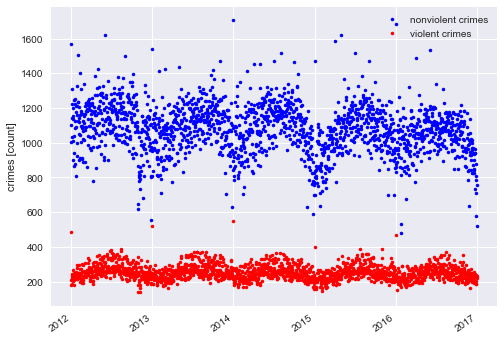

In [24]:
datetimes, violent_crime_counts = violent_crime_freq.keys(), violent_crime_freq.values
nonviolent_crime_counts = nonviolent_crime_freq.values
datetimes = pd.to_datetime(datetimes)

pl.figure(1)
pl.xticks(rotation=35, ha='right')
pl.plot(datetimes, nonviolent_crime_counts, 'b.', label='nonviolent crimes')
pl.plot(datetimes, violent_crime_counts, 'r.', label='violent crimes')
pl.ylabel('crimes [count]')
pl.legend(loc='best')
pl.show()

Each crime count clearly shows a periodic structure, with a period of one year.  Let's overlay the daily average temperature on our plot:

In [25]:
temp, temp_min, temp_max, precip, day_length, moon = [weather['%s' % key].values for key in \
                                                      ['avg_temp', 'min_temp', 'max_temp',
                                                      'precip', 'day_length', 'moon_pct']]

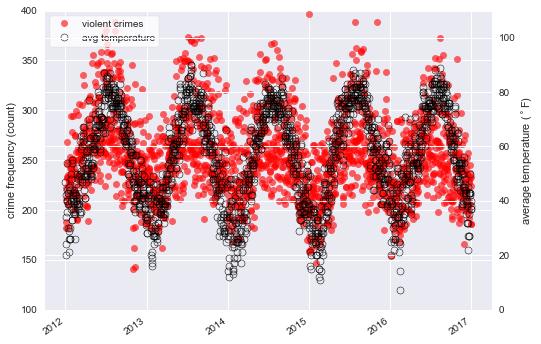

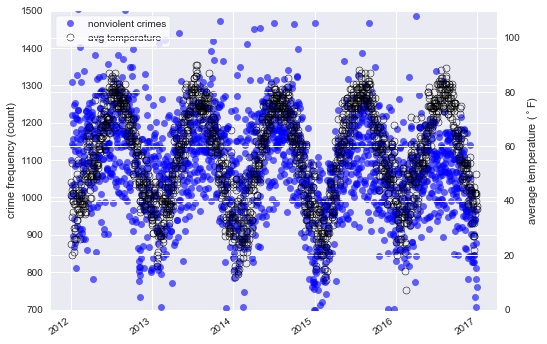

In [26]:
for count, color, ylim, label in zip([violent_crime_counts, nonviolent_crime_counts],
                               ['r', 'b'], [[100, 400], [700, 1500]], 
                               ['violent crimes', 'nonviolent crimes']):
    fig = pl.figure()
    ax1 = fig.add_subplot(111)
    pl.xticks(rotation=35, ha='right')
    ax1.plot(datetimes, count, '%so' % color, alpha=0.6, label=label)
    ax1.set_ylim(ylim)
    ax2 = ax1.twinx()
    ax2.plot(datetimes, temp, 'ko', fillstyle='none', 
             markeredgewidth=0.5, label='avg temperature')
    ax2.set_ylim(0, 110)
    ax1.set_ylabel('crime frequency (count)')
    ax2.set_ylabel('average temperature ($^\circ$F)')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=2, frameon=True, facecolor='w')
    pl.show()

By eye, this looks like a fairly close correlation!  Now let's see if we can quantify it . . .

### Measuring Correlation: Pearson Correlation Coefficient; Linear Fit and $R^2$

A complete analysis of time stream correlation would involve computing cross-correlation functions, examining the two time series for lags, etc.  Rather than do this, we'll do a naive, but dead-simple, quick-and-dirty measure of the crime frequency and average temperature time streams: we'll produce a simple linear regression and calculate the Person R correlation coefficient.

The Pearson R correlation coefficient is a number indicating the degree of linear correlation/anti-correlation between two variables.  It ranges from -1 (perfect linear anti-correlation), through 0 (no linear correlation) to +1 (perfect linear correlation).  Its calculation is implemented in the `scipy.stats.pearsonr()` function.

R-squared is the square of the Pearson R correlation coefficient.  It ranges from 0 to 1 and tells us the fraction of the variation in the response variable (here, daily crime count) that is explained by the linear model:

$$R^2~=~\text{explained variation / total variation}$$

It can be obtained directly, along with a linear fit of the data, by calling `scipy.stats.linregress(x, y)`.  This fails to give us a covariance matrix for the linear fit, however.  We'll therefore perform a fit separately using `np.polyfit(x, y, deg=1)` and will calculate $R^2$ explicitly from the fit using our own code.  

In [27]:
from scipy.stats import pearsonr
temp_violent_corr = pearsonr(temp, violent_crime_counts)[0]
temp_nonviolent_corr = pearsonr(temp, nonviolent_crime_counts)[0]

print temp_violent_corr, temp_nonviolent_corr

0.499230389437 0.443631633667


In [28]:
coeffs_temp_violent, cov_matrix_temp_violent = \
    np.polyfit(temp, violent_crime_counts, 1, cov=True)
m_temp_violent, b_temp_violent = coeffs_temp_violent[0], coeffs_temp_violent[1]
m_temp_violent_err = np.sqrt(cov_matrix_temp_violent[0][0])

print 'slope, slope error =', m_temp_violent, m_temp_violent_err

def calculate_rsquared(fitted_coeffs, x, y):
    p = np.poly1d(fitted_coeffs)
    y_hat = p(x)                  
    y_bar = np.sum(y)/len(y)      
    #ss_reg = np.sum((y_hat - y_bar)**2.)
    ss_tot = np.sum((y - y_bar)**2.)
    ss_res = np.sum((y - y_hat)**2.)
    return 1 - ss_res/ss_tot

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2.

R2_temp_violent = calculate_rsquared(coeffs_temp_violent, temp, 
                                     violent_crime_counts)

print 'R-squared (calculated) =', R2_temp_violent
print 'Sanity check: R-squared from scipy.stats.linregress = %s' % \
        rsquared(temp, violent_crime_counts)

slope, slope error = 1.22935413 0.0499730466468
R-squared (calculated) = 0.249276243543
Sanity check: R-squared from scipy.stats.linregress = 0.249230981738


Temperature and daily violent crime count show a positive linear correlation.  Our $R^2$ calculation shows that __a linear model fitting crime counts vs temperature explains 25% of the variation in the daiy violent crime count.__

Let's do the same calculations for our non-violent crime subset:

In [29]:
coeffs_temp_nonviolent, cov_matrix_temp_nonviolent = \
    np.polyfit(temp, nonviolent_crime_counts, 1, cov=True)
m_temp_nonviolent, b_temp_nonviolent = coeffs_temp_nonviolent[0], coeffs_temp_nonviolent[1]
m_temp_nonviolent_err = np.sqrt(cov_matrix_temp_nonviolent[0][0])

print 'slope, slope error =', m_temp_nonviolent, m_temp_nonviolent_err

R2_temp_nonviolent = calculate_rsquared(coeffs_temp_nonviolent, temp, 
                                        nonviolent_crime_counts)
print 'R-squared =', R2_temp_nonviolent

slope, slope error = 3.61967926471 0.171263043965
R-squared = 0.196809117888


For non-violent crimes the correlation coeffiient is slightly smaller; and __a linear fit to the data explains 20% of the variation in daily non-violent crime counts.__

Finally, we'll plot the data and the linear fits, with the correlation measures reported in the plot legends:

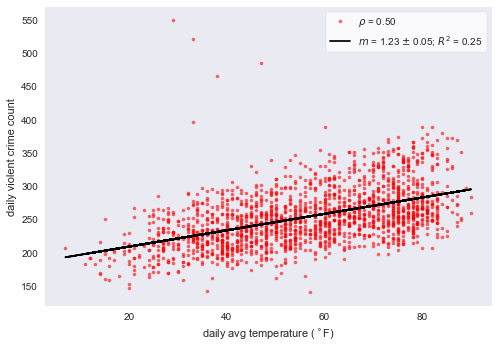

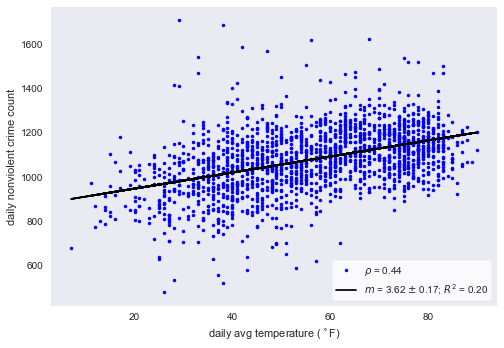

In [30]:
pl.figure()
pl.plot(temp, violent_crime_counts, 'r.', alpha=0.6, 
        label='$\\rho$ = %.2f' % temp_violent_corr)
pl.plot(temp, np.polyval(coeffs_temp_violent, temp), 'k-', 
        label='$m$ = %.2f $\pm$ %.2f; $R^2$ = %.2f' % 
        (m_temp_violent, m_temp_violent_err, R2_temp_violent))
pl.ylabel('daily violent crime count')
pl.xlabel('daily avg temperature ($^\circ$F)')
pl.legend(loc='best', frameon=True, facecolor='w')
pl.grid()
pl.show()

pl.figure()
pl.plot(temp, nonviolent_crime_counts, 'b.', 
        label='$\\rho$ = %.2f' % temp_nonviolent_corr)
pl.plot(temp, np.polyval(coeffs_temp_nonviolent, temp), 'k-', 
        label='$m$ = %.2f $\pm$ %.2f; $R^2$ = %.2f' % 
        (m_temp_nonviolent, m_temp_nonviolent_err, R2_temp_nonviolent))
pl.ylabel('daily nonviolent crime count')
pl.xlabel('daily avg temperature ($^\circ$F)')
pl.legend(loc='best', frameon=True, facecolor='w')
pl.grid()
pl.show()

### 3.2 Lunar Phase and Crime Rates

How does my grandparents' hypothesis about lunacy fare: what happens when we do the same exercise for the lunar phase instead of daily temperature?

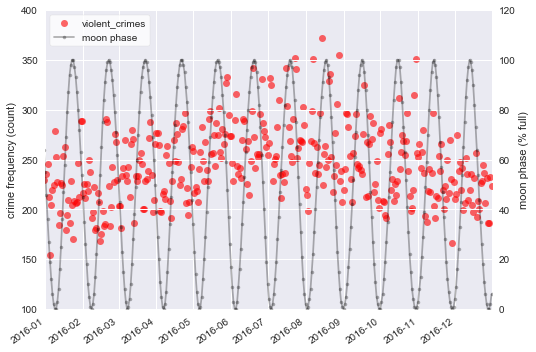

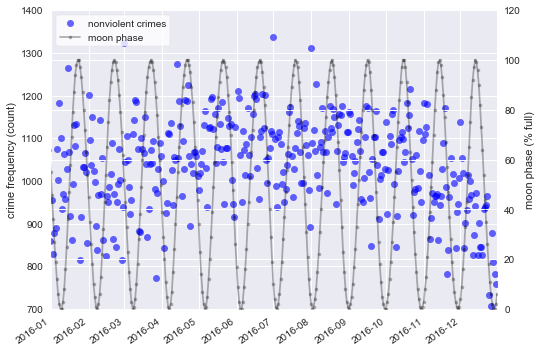

In [31]:
for crime_counts, color, label, ylim in zip([violent_crime_counts, nonviolent_crime_counts], 
                                            ['r', 'b'],
                                            ['violent_crimes', 'nonviolent crimes'],
                                            [[100, 400], [700, 1400]]):
    fig = pl.figure()
    ax1 = fig.add_subplot(111)
    pl.xticks(rotation=35, ha='right')
    ax1.plot(datetimes, crime_counts, '%so' % color, alpha=0.6, label=label)
    ax1.set_ylim(ylim)
    ax1.set_xlim('2016-01-01', '2016-12-31')
    ax2 = ax1.twinx()
    ax2.plot(datetimes, moon, 'k.-', alpha=0.3, label='moon phase')
    ax2.set_xlim('2016-01-01', '2016-12-31')
    ax2.set_ylim(0, 120)
    ax1.set_ylabel('crime frequency (count)')
    ax2.set_ylabel('moon phase (% full)')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=2, frameon=True, facecolor='w')
    pl.show()

In [32]:
moon_violent_corr = pearsonr(moon, violent_crime_counts)[0]
moon_nonviolent_corr = pearsonr(moon, nonviolent_crime_counts)[0]

print moon_violent_corr, moon_nonviolent_corr

-0.0202115488236 -0.0401618206007


In [33]:
coeffs_moon_violent, cov_matrix_moon_violent = \
    np.polyfit(moon, violent_crime_counts, 1, cov=True)
m_moon_violent, b_moon_violent = coeffs_moon_violent
m_moon_violent_err = np.sqrt(cov_matrix_moon_violent[0][0])

print 'slope, slope error =', m_moon_violent, m_moon_violent_err

R2_moon_violent = calculate_rsquared(coeffs_moon_violent, moon, 
                                     violent_crime_counts)
print 'R-squared =', R2_moon_violent

slope, slope error = -0.0247220892473 0.0286420116007
R-squared = 0.000468769336247


In [34]:
coeffs_moon_nonviolent, cov_matrix_moon_nonviolent = \
    np.polyfit(moon, nonviolent_crime_counts, 1, cov=True)
m_moon_nonviolent, b_moon_nonviolent = coeffs_moon_nonviolent
m_moon_nonviolent_err = np.sqrt(cov_matrix_moon_nonviolent[0][0])

print 'slope, slope error =', m_moon_nonviolent, m_moon_nonviolent_err

R2_moon_nonviolent = calculate_rsquared(coeffs_moon_nonviolent, moon, 
                                        nonviolent_crime_counts)
print 'R-squared =', R2_moon_violent

slope, slope error = -0.162768574393 0.0948447504956
R-squared = 0.000468769336247


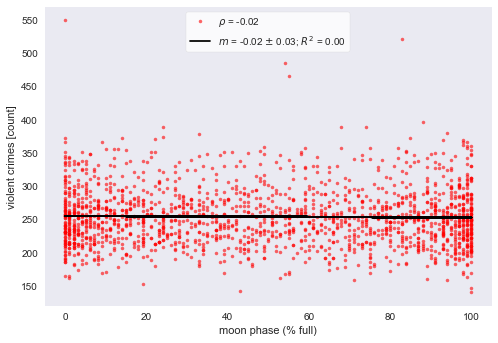

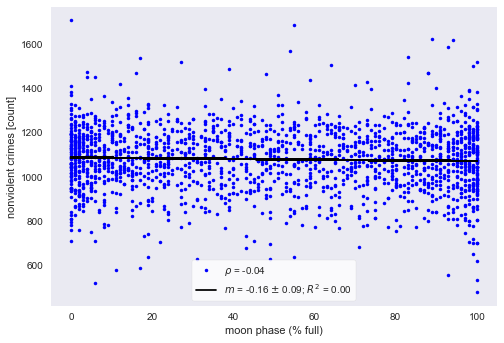

In [35]:
pl.figure()
pl.plot(moon, violent_crime_counts, 'r.', alpha=0.6, 
        label='$\\rho$ = %.2f' % moon_violent_corr)
pl.plot(moon, np.polyval(coeffs_moon_violent, moon), 'k-', 
        label='$m$ = %.2f $\pm$ %.2f; $R^2$ = %.2f' % 
        (m_moon_violent, m_moon_violent_err, R2_moon_violent))
pl.ylabel('violent crimes [count]')
pl.xlabel('moon phase (% full)')
pl.legend(loc='best', frameon=True, facecolor='w')
pl.grid()
pl.show()

pl.figure()
pl.plot(moon, nonviolent_crime_counts, 'b.', 
        label='$\\rho$ = %.2f' % moon_nonviolent_corr)
pl.plot(moon, np.polyval(coeffs_moon_nonviolent, moon), 'k-', 
        label='$m$ = %.2f $\pm$ %.2f; $R^2$ = %.2f' % 
        (m_moon_nonviolent, m_moon_nonviolent_err, R2_moon_nonviolent))
pl.ylabel('nonviolent crimes [count]')
pl.xlabel('moon phase (% full)')
pl.legend(loc='best', frameon=True, facecolor='w')
pl.grid()
pl.show()

----
# 4. Are Crimes More or Less Likely to Occur on Weekends?

## 4.1 Exploring the Data

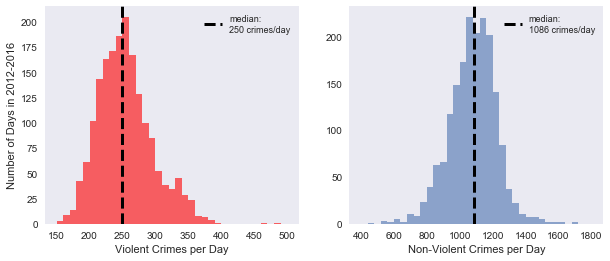

In [36]:
bin_width = 10
bins_violent = np.arange(150, 500+bin_width, bin_width)

bin_width = 40
bins_nonviolent = np.arange(400, 1800+bin_width, bin_width)

pl.figure(figsize=(10,4))
pl.subplot(121)
pl.hist(violent_crime_counts, bins=bins_violent, color='red', alpha=0.6)
median = int(np.median(violent_crime_counts))
pl.axvline(x=median, color='k', ls='--', lw=3, label='median:\n%s crimes/day' % median)
pl.xlabel('Violent Crimes per Day')
pl.ylabel('Number of Days in 2012-2016')
pl.legend(fontsize=9)
pl.grid()

pl.subplot(122)
pl.hist(nonviolent_crime_counts, bins=bins_nonviolent, alpha=0.6)
median = int(np.median(nonviolent_crime_counts))
pl.axvline(x=median, color='k', ls='--', lw=3, label='median:\n%s crimes/day' % median)
pl.xlabel('Non-Violent Crimes per Day')
pl.legend(fontsize=9)
pl.grid()
pl.show()

First let's divide each data set into two subsets: crime rates for weekdays vs crime rates for weekends.  Then we'll re-do the histograms for each data subset.  We will also perform a least-squares fit to a Gaussian distribution for each subset.

In [37]:
weekday = weather.day_of_week.values
is_weekend = (weekday == 'Sat') | (weekday == 'Sun')

weekend_violent_crime_counts = violent_crime_counts[is_weekend]
weekday_violent_crime_counts = violent_crime_counts[~is_weekend]

weekend_nonviolent_crime_counts = nonviolent_crime_counts[is_weekend]
weekday_nonviolent_crime_counts = nonviolent_crime_counts[~is_weekend]

We now have our four data subsets: violent/non-violent crimes committed on weekdays/weekends.  Now let's histogram each subset and fit a Gaussian distribution to each histogram.  For this purpose we'll use the following fitting code:

In [38]:
def fit_gaussian(xdata, ydata):
    '''
    A function to perform a least-squares fit to a Gaussian distribution.
    Inputs: xdata and ydata = x and y values of the data to fit
    Outputs: amplitude, mean, and standard deviation of the Gaussian fit
    '''
    fitfunc = lambda p, x: p[0] * np.exp(-1.*(p[1] - x)**2. / (2.*p[2]**2.)) 
    errfunc = lambda p, x, y: fitfunc(p, x) - y
    # Initial guesses:
    p = [pl.nan, pl.nan, pl.nan]
    p[0] = max(ydata)
    p[1] = xdata[np.where(ydata == max(ydata))[0]][0]
    p[2] = np.std(xdata)#xdata[1] - xdata[0]  # Assume a wide distribution to start
    p1, success = scipy.optimize.leastsq(errfunc, p[:], args=(xdata, ydata))
    return p1[0],  p1[1], abs(p1[2])

For convenience we'll create a dictionary to store the fitted parameters for each data set. We initialize the data dictionary first, then populate it using the code immediately following.

In [39]:
gaussian_fits = {'violent': {'weekdays': {'data': weekday_violent_crime_counts, 'mu':pl.nan, 
                                          'sigma':pl.nan, 'fit_y':pl.nan, 'fit_x':pl.nan}, 
                             'weekends': {'data': weekend_violent_crime_counts, 'mu':pl.nan, 
                                          'sigma':pl.nan, 'fit_y':pl.nan, 'fit_x':pl.nan}},
                 'nonviolent': {'weekdays': {'data': weekday_nonviolent_crime_counts, 'mu':pl.nan, 
                                             'sigma':pl.nan, 'fit_y':pl.nan, 'fit_x':pl.nan}, 
                                'weekends': {'data': weekend_nonviolent_crime_counts, 'mu':pl.nan, 
                                             'sigma':pl.nan, 'fit_y':pl.nan, 'fit_x':pl.nan}}}

for isviolent in ['violent', 'nonviolent']:
    for isweekday in ['weekdays', 'weekends']:
        bins = bins_violent
        if isviolent == 'nonviolent':
            bins = bins_nonviolent
        dataset = gaussian_fits[isviolent][isweekday]['data']
        bin_counts, bin_edges, patches = pl.hist(dataset, bins=bins)
        pl.clf()
        bin_centers = (bins + 0.5*(bins[1] - bins[0]))[:-1]
        amplitude, mu, sigma = fit_gaussian(bin_centers, bin_counts)
        fit_x = np.arange(min(bins), max(bins), 0.1)
        fit_y = amplitude * np.exp(-1. * (fit_x - mu)**2. / (2.*sigma**2.))
        gaussian_fits[isviolent][isweekday]['mu'] = mu
        gaussian_fits[isviolent][isweekday]['sigma'] = sigma
        gaussian_fits[isviolent][isweekday]['fit_y'] = fit_y
        gaussian_fits[isviolent][isweekday]['fit_x'] = fit_x

# Bug? Gaussian fit y-values for nonviolent weekend crimes plot incorrectly unless we re-do them
bins = bins_nonviolent
bin_counts, bin_edges, patches = pl.hist(weekend_nonviolent_crime_counts, bins=bins)
pl.clf()
bin_centers = (bins + 0.5*(bins[1] - bins[0]))[:-1]
amplitude, mu, sigma = fit_gaussian(bin_centers, bin_counts)
fit_x = np.arange(min(bins), max(bins), 0.1)
fit_y = amplitude * np.exp(-1 * (fit_x - mu)**2 / (2*sigma** 2))
gaussian_fits['nonviolent']['weekends']['mu'] = mu
gaussian_fits['nonviolent']['weekends']['sigma'] = sigma
gaussian_fits['nonviolent']['weekends']['fit_y'] = fit_y
gaussian_fits['nonviolent']['weekends']['fit_x'] = fit_x

We have our data and we're nearly done: let's make the plot!

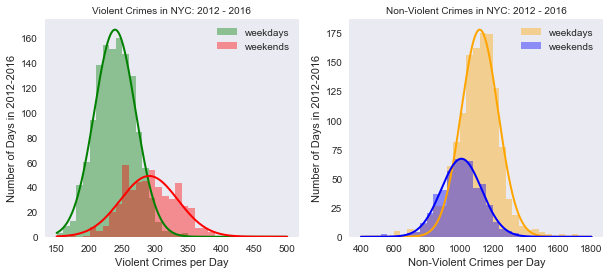

In [40]:
pl.figure(figsize=(10,4))
pl.subplot(121)
pl.title('Violent Crimes in NYC: 2012 - 2016', fontsize=10)
pl.hist(weekday_violent_crime_counts, bins=bins_violent, color='green', 
        alpha=0.4, label='weekdays')
fit = gaussian_fits['violent']['weekdays']
pl.plot(fit['fit_x'], fit['fit_y'], color='green', lw=2)
pl.hist(weekend_violent_crime_counts, bins=bins_violent, color='red', 
        alpha=0.4, label='weekends')
fit = gaussian_fits['violent']['weekends']
pl.plot(fit['fit_x'], fit['fit_y'], color='red', lw=2)
pl.xlabel('Violent Crimes per Day')
pl.ylabel('Number of Days in 2012-2016')
pl.grid()
pl.legend()

pl.subplot(122)
pl.title('Non-Violent Crimes in NYC: 2012 - 2016', fontsize=10)
pl.hist(weekday_nonviolent_crime_counts, bins=bins_nonviolent, color='orange', 
        alpha=0.4, label='weekdays')
fit = gaussian_fits['nonviolent']['weekdays']
pl.plot(fit['fit_x'], fit['fit_y'], color='orange', lw=2)
pl.hist(weekend_nonviolent_crime_counts, bins=bins_nonviolent, color='blue', 
        alpha=0.4, label='weekends')
fit = gaussian_fits['nonviolent']['weekends']
pl.plot(fit['fit_x'], fit['fit_y'], color='blue', lw=2)
pl.xlabel('Non-Violent Crimes per Day')
pl.ylabel('Number of Days in 2012-2016')
pl.grid()
pl.legend()
pl.show()

__What are these plots telling us?__
  * Let's start by describing what they signify.  These are histograms of daily crime counts, where each binned data point corresponds to the number of crimes on a single day during 2012-2016. 
    * The peak of the green histogram, for example, tells us there were 160 weekdays during 2012-2016 when somewhere between 240 to 250 violent crimes were committed.  
    * The data are separated between violent crimes (left panel) and non-violent crimes (right panel); and within each panel, the data are separated again (by color) between crimes committed on weekdays vs crimes committed on weekends. 
  * It looks like our intuition to separate the data into weekend vs weekday crimes was correct.  
    * The distributions look more Gaussian after having made this separation.  (Compare the histograms of the combined weekend + weekday crimes above, which skew left (right) for violent (non-violent) crimes.)
    * The distribution for violent weekend crimes (red) looks a bit off, but this may be due to the small sample size (105 samples, as opposed to more than 1000 samples for each of the other distributions).

Taken at face value, __these distributions imply that the average crime rate _increases_ on weekends for violent crimes, but _decreases_ on weekends for non-violent crimes.__  This can be seen by comparing the location of the peaks of our Gaussian fits: for violent crimes the peak of the weekend-only data is to the right of the weekday-only data, while for non-violent crimes the situation is reversed.  But how meaningful is this difference?

----

## 4.2 Is the Difference between the Distributions' Mean Values Statistically Significant?

The weekend vs weekday crime rates clearly have different means, as shown by the peaks of the Gaussian fits.  But how statistically significant is that difference?  

To answer this question we need to do some hypothesis testing.  We: 
  * Provisionally assume the _null hypothesis_ that the means of the parent distributions from which the data sets were drawn are equal.  
  * Apply some statistical significance test (more on this below) to obtain a _p-value_.  The p-value tells us the chance we would observe a difference in means _equal to or greater than_ the difference for our data samples, _assuming_ the null hypothesis is in fact true (i.e., assuming that the means of the parent distributions from which they were sampled are actually identical).
  * Reject the null hypothesis (i.e., conclude that the difference in means is statistically significant) if the p-value falls below some threshold, e.g., 0.05. 

### Which statistical significance test to apply?

But which significance test we apply depends on whether the distributions are Gaussian.  
  * __If the data sets are Gaussian:__ we can perform a __[two-sample t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)__ to test the statistical significance of the difference between the means of the weekend and weekday data sets.  To find the p-value we would call the `scipy.stats.ttest_ind()` function with the argument `equal_var=False` (since the variances of the distributions aren't equal).
  * __If the data sets aren't Gaussian:__ in this case the t-test could give the wrong result.  For non-Gaussian distributions the __[Mann-Whitney U-test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)__ is a good option.  (Technically, it tests the null hypothesis that it's equally likely that a randomly selected value from one data set will be less than or greater than a randomly selected sample from the second set.)  Unlike the t-test, it does not require us to assume the two distributions are Gaussian.  The test can be applied to Gaussian distributions as well, but in that instance is slightly less efficient than the t-test.  To find the p-value we would call `scipy.stats.mannwhitneyu()` function.  But we have to be careful to double the returned value to perform a two-tailed test rather than a one-tailed test.
  
### Testing for Gaussianity

The histograms above _look_ more or less Gaussian to the eye, and _appear_ to follow the Gaussian fits fairly well.  But are the distributions in fact Gaussian -- or at least sufficiently Gaussian to apply the t-test?  Are the ditributions skewed or heavy/light in their tails?

There are many methods for testing the Gaussianity of a distribution.  We'll describe a few, and will choose one from among them:
  1. __Calculating skewness and kurtosis:__ These are respectively the 3rd and 4th moments of the samples about the mean value, expressed in units of standard deviation.  
    - [Skewness](https://en.wikipedia.org/wiki/Skewness) provides a measure of the asymmetry of a distribution.  For a perfectly Gaussian distribution, $\gamma_1~=~0$.  $\gamma_1$ deviates below (above) 0 as the distribution skews left (right).  
    - [Kurtosis](https://en.wikipedia.org/wiki/Kurtosis) (K) provides a measure of the "tailedness" of a distribution.  For a perfectly Gaussian distribution, K = 3.  K deviates below (above) 3 as the distribution has fatter (thinner) tails.  The `scipy.stats` library comes with built-in `skew()` and `kurtosis()` functions.
  2. __Histogramming, fitting a Gaussian function, and performing a Chi-squared Goodness of Fit test:__  Why not histogram your data, fit a Gaussian distribution to the counts in each bin, then calculate the [reduced chi-squared statistic](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic) for the fit?  This option sounds reasonable and is often used, but it's also easy to abuse.  This method raises at least two concerns that must be addressed:
    - The histogrammed data distribution is sensitive to the selecetd bin width, and choosing a proper bin width can be a challenge; [algorithms and rules-of-thumb](https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram) can help, but bin width selection is part art and part science.  
    - In addition, the errors we assign to the bin counts need to be handled appropriately.  Histogramming data samples that were drawn from a Gaussian distribution gives an overall shape that is Gaussian; but _the sample count within each bin_ follows a Poisson distribution.  The error associated with each bin count isn't the standard deviation of the binned samples; it's the square root of the observed bin count.  (These two values are roughly equal in the large sample limit, but differ dramatically for low-count bins.)  See Bevington's [Data Reduction and Error Analysis in the Physical Sciences](https://www.amazon.com/Reduction-Error-Analysis-Physical-Sciences/dp/0072472278) for more on this point.  
  3. __The Anderson-Darling Test:__ This modified version of the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) is used to determine whether a sampled data set comes from a specified parent distribution.  See [Wikipedia's Anderson-Darling Test article](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test) for more details.  It is implemented in the `scipy.stats.anderson()` function.
  4. __The Shapiro-Wilk Test:__  The [SW-test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) is yet another method for determining whether a sampled data set comes from a specified distribution.  It is implemented in the `scipy.stats.shapiro()` function.

[Studies show](https://www.researchgate.net/publication/267205556_Power_Comparisons_of_Shapiro-Wilk_Kolmogorov-Smirnov_Lilliefors_and_Anderson-Darling_Tests) that the Shapiro-Wilk test has the best power for a given level of significance.  It's also quick and easy to implement in Python.  __We'll choose the Shapiro-Wilk Test as our test for Gaussianity.__  

In addition to calculating the Shapiro-Wilk p-value for each of our four distributions, we'll also use `scipy.stats.probplot()` to generate an accompanying __Q-Q (quartile-quartile) plot__ to compare the data's quantiles with those expected for a normal distribution. A Q-Q plot is a scatter plot of the data set's quantiles against the quantiles of a known theoretical distribution -- in this case, the normal distribution. If the distributions are similar the Q-Q plot will follow a straight line.  QQ-plots are helpful for observing the skewness and "tailedness" of a distribution, essentially obviating the need to perform the calculations in option (1).

For comparison, here is what the Q-Q plot and Shapiro-Wilk test looks like when applied to a Gaussian distribution:

Shapiro‐Wilk p‐value: 0.996 (Non-Gaussian = False)


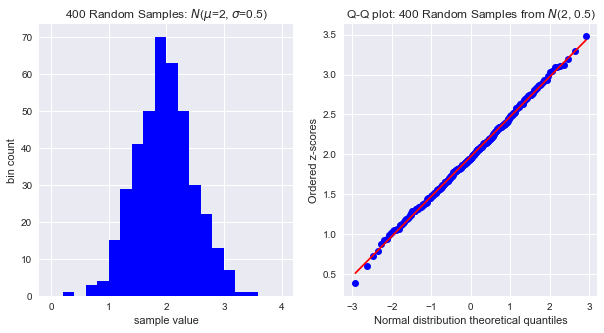

In [41]:
# Generate 500 samples from a Gaussian parent distribution with mean=2, std=0.5
np.random.seed(123)
dataset = np.random.normal(loc=2.0, scale=0.5, size=400) 
SW_pvalue = scipy.stats.shapiro(dataset)[1]
nongaussian = SW_pvalue <= 0.05
print 'Shapiro‐Wilk p‐value: %.3f (Non-Gaussian = %s)' % (SW_pvalue, nongaussian)

pl.figure(figsize=(10,5))
pl.subplot(121)
pl.hist(dataset, bins=np.arange(0,4.2,0.2), color='b')
pl.title('400 Random Samples: $N$($\mu$=2, $\sigma$=0.5)')
pl.xlabel('sample value')
pl.ylabel('bin count')
pl.subplot(122)
scipy.stats.probplot(dataset, dist='norm', plot=pl)
pl.title('Q-Q plot: 400 Random Samples from $N$(2, 0.5)')
pl.xlabel('Normal distribution theoretical quantiles')
pl.ylabel('Ordered z-scores')
pl.show()

For this simulated Gaussian data the p-value (0.996) is very large -- nowhere near our 0.05 statistical significance cutoff -- meaning we can't reject the null hypothesis that the parent distribution is normal.  In addition, the Q-Q plot shows that the data generally follow a nice, straight lines, with some small variation in the tails.  

## 4.3 Results:

How do our crime rate distributions compare?

violent crimes on weekdays:
Shapiro‐Wilk p‐value: 0.000 (Non-Gaussian = True)



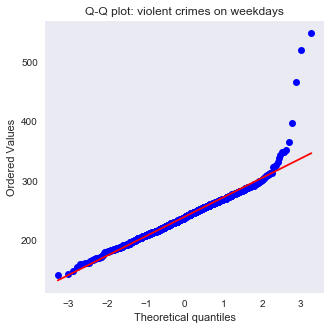

violent crimes on weekends:
Shapiro‐Wilk p‐value: 0.001 (Non-Gaussian = True)



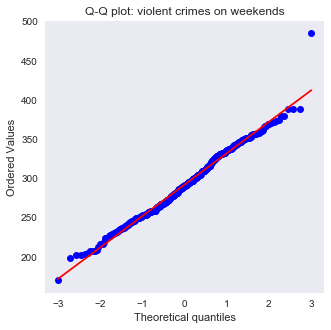

nonviolent crimes on weekdays:
Shapiro‐Wilk p‐value: 0.000 (Non-Gaussian = True)



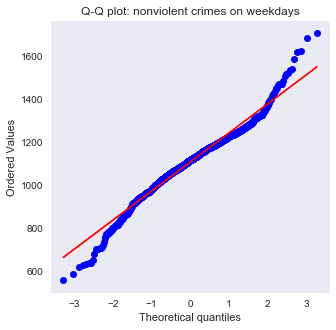

nonviolent crimes on weekends:
Shapiro‐Wilk p‐value: 0.000 (Non-Gaussian = True)



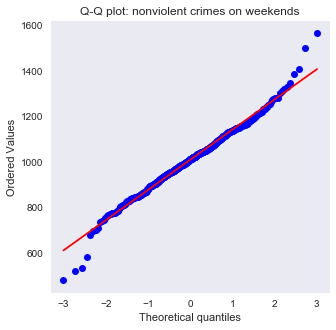

In [42]:
# Test for normality: p-values less than 0.05 are NOT normal
for isviolent in ['violent', 'nonviolent']:
    for isweekday in ['weekdays', 'weekends']:
        dataset = gaussian_fits[isviolent][isweekday]['data']
        SW_pvalue = scipy.stats.shapiro(dataset)[1]
        nongaussian = SW_pvalue <= 0.05
        print '%s crimes on %s:\nShapiro‐Wilk p‐value: %.3f (Non-Gaussian = %s)\n' % \
            (isviolent, isweekday, SW_pvalue, nongaussian)
        pl.figure(figsize=(5,5))
        scipy.stats.probplot(dataset, dist='norm', plot=pl)
        pl.title('Q-Q plot: %s crimes on %s' % (isviolent, isweekday))
        pl.grid()
        pl.show()

It's a good thing we didn't trust our eyes: none of the distributions is Gaussian according to the Shapiro-Wilk test.  And the accompanying Q-Q plots show both fatness in the tails, and some visually apparent skewness.  

We can now answer our question: __since the distributions aren't sufficiently Gaussian, we should apply the Mann-Whitney U-test, _not_ the t-test,__ to test the statistical significance of the difference between the means of our distributions.

First let's perform the Mann-Whitney U-test for the two _violent_ crime rate distributions: is there a statistically  significant difference between the mean crime rates for violent crimes committed on weekends vs weekdays?

In [43]:
mu1, sigma1, data1 = [gaussian_fits['violent']['weekdays'][x] for 
                      x in ['mu', 'sigma', 'data']]
mu2, sigma2, data2 = [gaussian_fits['violent']['weekends'][x] for 
                      x in ['mu', 'sigma', 'data']]
#t_test = scipy.stats.ttest_ind(weekday_violent_crime_counts, 
#                               weekend_violent_crime_counts, equal_var=False)

print 'Violent Crimes per Day: Weekends vs Weekdays'
print 'Difference in Means: %s crimes/day' % int(mu2 - mu1)
#print 'Two-sample t-test p-value:', t_test[1]
print 'Mann-Whitney U-Test p-value:', 2*scipy.stats.mannwhitneyu(data1, data2)[1]

Violent Crimes per Day: Weekends vs Weekdays
Difference in Means: 51 crimes/day
Mann-Whitney U-Test p-value: 8.98657980415e-123


The p-value is essentially zero: we reject the null hypothesis and conclude that the difference between the mean crime rates (51 days) is significant.

How about the weekend vs weekday ditributions for _non-violent_ crime rates?

In [44]:
mu1, sigma1, data1 = [gaussian_fits['nonviolent']['weekdays'][x] for 
                      x in ['mu', 'sigma', 'data']]
mu2, sigma2, data2 = [gaussian_fits['nonviolent']['weekends'][x] for 
                      x in ['mu', 'sigma', 'data']]

print 'Non-violent Crimes per Day: Weekends vs Weekdays'
print 'Difference in Means: %s crimes/day' % int(mu2 - mu1)
#print 'Two-sample t-test p-value:', t_test[1]
print 'Mann-Whitney U-Test p-value:', 2*scipy.stats.mannwhitneyu(data1, data2)[1]

Non-violent Crimes per Day: Weekends vs Weekdays
Difference in Means: -110 crimes/day
Mann-Whitney U-Test p-value: 3.95173791782e-46


Again we find that the difference between the means is statistically significant.